In [21]:
import utils
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from utils import MyDataLoader
DL = MyDataLoader()
DL.read_gt("data/clusters.csv")
DL.data.head(10)

INFO:root:Loaded 1521 images


,Unnamed: 0,cluster_id,file_name,cluster_num
0,0,5f1f5a4cb43b4a13b1f281d951ed7517,a00ee19f8bdd48a3af5ff78789887ad1.jpg,354
1,1,5f1f5a4cb43b4a13b1f281d951ed7517,9a34cabc4be94126a958267e2e3d1676.jpg,354
2,2,5f1f5a4cb43b4a13b1f281d951ed7517,381529cfa29942f3a30cb35247ff1c63.jpg,354
3,3,5f1f5a4cb43b4a13b1f281d951ed7517,c646ed62b45145c682733cfce9c815d7.jpg,354
4,4,5f1f5a4cb43b4a13b1f281d951ed7517,6a5d90d13fdc47348753144d5a33be71.jpg,354
5,5,5f1f5a4cb43b4a13b1f281d951ed7517,8da290af60ab462c911aaa603824fd52.jpg,354
6,6,5f1f5a4cb43b4a13b1f281d951ed7517,1a6f1972db7e41fdb731bd47433e2090.jpg,354
7,7,5f1f5a4cb43b4a13b1f281d951ed7517,3e7a3af1e0644d9bb417f0b051a8e0ec.jpg,354
8,8,5f1f5a4cb43b4a13b1f281d951ed7517,9ef20db40f2f4cc79efeb76ef5562cf0.jpg,354
9,9,5f1f5a4cb43b4a13b1f281d951ed7517,af1c87f519f2493980cbcd9cc11f5eb6.jpg,354


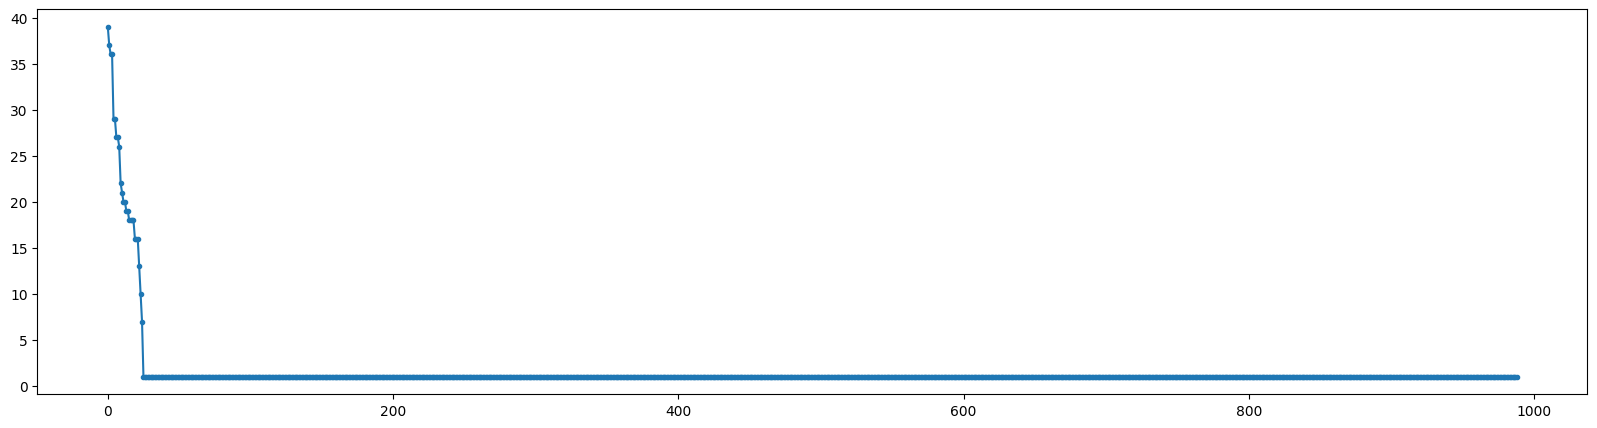

In [24]:
plt.subplots(figsize=(20, 5))
DL.show_stats();

In [25]:
DL.read_encodings("encodings.pkl")

INFO:root:Loaded 1521 encodings


In [40]:
x, y = DL.get_xy()

INFO:root:Sync images with faces. Encodings x: (596, 128), labeled clusters y:(596,)


0.37901694138671443


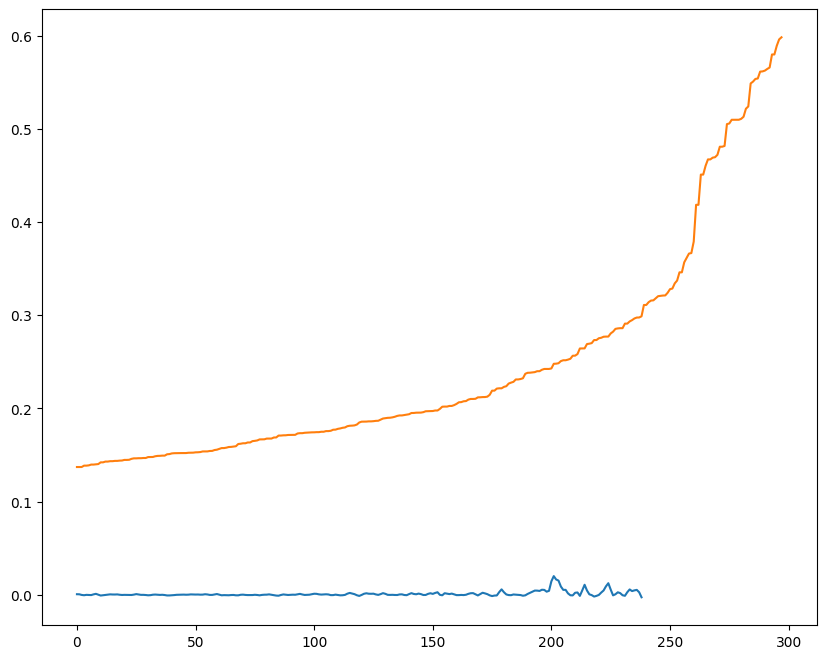

In [87]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
nn = NearestNeighbors(n_neighbors=10).fit(x)
distances, indices = nn.kneighbors(x)
distances = distances[:, 1]
distances = np.sort(distances, axis=0)
l0 = int(len(distances)/2)
distances = distances[l0:]

dd = np.gradient(np.gradient(distances, 1), 1)
dd = np.convolve(dd, np.ones(60), "valid")
plt.figure(figsize=(10,8))
plt.plot(dd)
plt.plot(distances)

print(distances[200+60])


In [73]:
len(distances[int(len(distances)/2):])

149

In [98]:
from sklearn.cluster import DBSCAN
import numpy as np



output = []

for ms in range(2, 10):
    for ep in np.arange(0.2, 1., 0.1):
        labs = DBSCAN(min_samples=ms, eps = ep).fit(x).labels_
        if sum(labs):
            score = silhouette_score(x, labs)
            output.append((ms, ep, score))

min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

labs = DBSCAN(min_samples=min_samples, eps = eps).fit(x).labels_
labelIDs = np.unique(labs)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

Best silhouette_score: 0.4261512148943709
min_samples: 2
eps: 0.4000000000000001
[INFO] # unique faces: 25


In [99]:
from sklearn.metrics import v_measure_score
v_measure_score(y, labs)

0.9376759595461605

In [39]:
# loop over the unique face integers
for labelID in labelIDs:
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    print("[INFO] faces for face ID: {}".format(labelID))
    idxs = np.where(clt.labels_ == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)),
        replace=False)
    # initialize the list of faces to include in the montage
    faces = []
    # loop over the sampled indexes
    for i in idxs:
        # load the input image and extract the face ROI
        try:
            image = cv2.imread(data[i]["imagePath"])
            (top, right, bottom, left) = data[i]["loc"]
            face = image[top:bottom, left:right]
            # force resize the face ROI to 96x96 and then add it to the
            # faces montage list
            face = cv2.resize(face, (96, 96))
            faces.append(face)
        except:
            pass
    # create a montage using 96x96 "tiles" with 5 rows and 5 columns
    montage = build_montages(faces, (96, 96), (5, 5))[0]
    
    # show the output montage
    title = "Unknown Faces" if labelID == -1 else "Face ID #{}".format(labelID)
    plt.imshow(montage)
    plt.axis("off")
    plt.title(title)
    plt.savefig(f"{labelID:03.0f}.png")


[INFO] faces for face ID: -1


NameError: name 'build_montages' is not defined